In [161]:
import networkx as nx
import pandas
from hatchet import *
import os
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import igraph
import platform

In [162]:
# libraries for gromov distance computation.
import numpy as np
import scipy as sp
import ot
from sklearn.decomposition import PCA
from sklearn import manifold

In [2]:
from actions.groupBy import groupBy
from state import State
from callgraph import CallGraph
from preprocess import PreProcess

In [3]:
%matplotlib inline

In [4]:
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:,.2f}'.format
plt.rcParams['figure.figsize'] = (16, 12)

In [197]:
# Linux path
if platform.system() == "Linux":
    callflow_path = "/home/vidi/Work/llnl/CallFlow/"
else:
    #Mac OSx path
    callflow_path = "/Users/jarus/ucd/Research/Visualisation/projects/CallFlow"

dataset_path = ["data/lulesh-1/db-ampi4-100-1", "data/lulesh-1/hpctoolkit-database"]
dataset = ['db-ampi4-100-1', 'hpctoolkit-database']    

In [198]:
# Create Graphframes.
def create_gfs(file_format, paths):    
        print("Creating graphframes....")                                                                                             
        ret = []                                                                                                                         
        for idx, path in enumerate(paths):
            path = os.path.abspath(os.path.join(callflow_path, path)) 
            gf = GraphFrame()   
            gf.from_hpctoolkit(path, 3)                                                                            
            ret.append(gf) 
            print(str(idx) + ":" + path)                                                                                              
            print("[Create] Rows in dataframe: {0}".format(gf.dataframe.shape[0]))                       
        return ret 

gfs = create_gfs('hpctoolkit', dataset_path)

Creating graphframes....
0:/home/vidi/Work/llnl/CallFlow/data/lulesh-1/db-ampi4-100-1
[Create] Rows in dataframe: 185290
1:/home/vidi/Work/llnl/CallFlow/data/lulesh-1/hpctoolkit-database
[Create] Rows in dataframe: 470580


In [199]:
# util functions
def lookup(df, node):                                                                                                                    
    return df.loc[df['node'] == node] 

def lookup_with_name(df, name):
    return df.loc[df['name'] == name]

def getMaxIncTime(gf):                                                                                                                   
    ret = 0.0                                                                                                                            
    for root in gf.graph.roots:                                                                                                          
        ret = max(ret, lookup(gf.dataframe, root)['CPUTIME (usec) (I)'].max())                                                           
    return ret                                                                                                                           
                                                                                                                                         
def getMaxExcTime(gf):                                                                                                                   
    ret  = gf.dataframe['CPUTIME (usec) (E)'].max()                                                                                      
    return ret                                                                                                                           
               
def special_lookup(gf, df_index):   
    return gf.dataframe.loc[gf.dataframe['name'] == df_index] 

In [200]:
# Filter graphframe and graph
def filter_gfs(gfs, filterBy):                                                                                                   
    # Create the graph frames from the paths and corresponding format using hatchet                                                  
    fgfs = []                                                                                                                        
    # Filter graphframes based on threshold                                                                                          
    for idx, gf in enumerate(gfs):                                                                                              
        print("Filtering the dataframe!")                                                                                         
        if filterBy == "IncTime":                                                                                          
            max_inclusive_time = getMaxIncTime(gf)                                                                             
            filter_gf = gf.filter(lambda x: True if(x['CPUTIME (usec) (I)'] > 0.01*max_inclusive_time) else False)                   
        elif self.args.filterBy == "ExcTime":                                                                                        
            max_exclusive_time = getMaxExcTime(gf)                                                                             
            print('[Filter] By Exclusive time = {0})'.format(max_exclusive_time))                                                 
            filter_gf = gf.filter(lambda x: True if (x['CPUTIME (usec) (E)'] > 0.01*max_exclusive_time) else False)                  
        else:                                                                                                                        
            print("Not filtering.... Can take forever. Thou were warned")                                                         
            filter_gf = gf                                                                                                           
        print('[Filter] Removed {0} rows.)'.format(gf.dataframe.shape[0] - filter_gf.dataframe.shape[0]))                                                                                                                            
        print("Grafting the graph!")                                                                                            
        filter_gf = filter_gf.graft()                                                                                                
        print("[Graft] {0} rows left".format(filter_gf.dataframe.shape[0]))                           
        fgfs.append(filter_gf)                                                                                                       
    return fgfs      

# filtered graph frames.
fgfs = filter_gfs(gfs, 'IncTime')    

Filtering the dataframe!
(185290, 10)
[Filter] Removed 184465 rows.)
Grafting the graph!
[Graft] 825 rows left
Filtering the dataframe!
(470580, 10)
[Filter] Removed 469985 rows.)
Grafting the graph!
[Graft] 595 rows left


In [201]:
# Print filtered graph information. 
for idx, fgf in enumerate(fgfs):
    print("Shape of the dataframe from graph ({0}): {1}".format(dataset[idx], fgf.dataframe.shape))

Shape of the dataframe from graph (db-ampi4-100-1): (825, 10)
Shape of the dataframe from graph (hpctoolkit-database): (595, 10)


In [202]:
# add n_index to the dataframe.
def add_n_index(gf):
    gf.dataframe['n_index'] = gf.dataframe.groupby('nid').ngroup()

In [203]:
# ret = {
#   node_name : df_index
#}
def df_index_name_mapper(graph, df):
    ret = {}
    node_count = 0
    root = graph.roots[0]
    node_gen = graph.roots[0].traverse()
    try:
        while root.callpath != None:
            node_count += 1
            root = next(node_gen)
            ret[root.callpath[-1]] = root.df_index
    except StopIteration:
        pass
    finally:
        print("Total nodes in graph: ", node_count)
        del root
    return ret

# add df_index to the dataframe
def add_df_index(gf):
    df_index_name_map = df_index_name_mapper(gf.graph, gf.dataframe)
    gf.dataframe['df_index'] = gf.dataframe['name'].apply(lambda node: df_index_name_map[node] if node in df_index_name_map else 'as ')   

In [204]:
# add callee and caller data into the dataframe
def add_callers_and_callee(graph, df):
    callees = {}
    callers = {}
    root = graph.roots[0]
    node_gen = graph.roots[0].traverse()
    root_df = root.callpath[-1]
    callers[root_df] = []
    callees[root_df] = []
    try:                                                                                                                        
        while root.callpath != None:                                                                                            
            root = next(node_gen)                                                                                               
            if root.parent:                                                                                                     
                root_df = root.callpath[-1]                                                                                     
                parent_df = root.parent.callpath[-1]                                                                            
                if parent_df not in callees:                                                                                    
                    callees[parent_df] = []              
                callees[parent_df].append(root_df)                                                                              
                                                                                                                                        
                if root_df not in callers:                                                                                      
                    callers[root_df] = []                                                                                       
                callers[root_df].append(parent_df)                                                                              
                                                                                                                                        
    except StopIteration:                                                                                                       
        pass                                                                                                                    
    finally:                                                                                                                    
        del root                                                                                                                
                                                                                                                                        
    df['callees'] = df['name'].apply(lambda node: callees[node] if node in callees else [])                           
    df['callers'] = df['name'].apply(lambda node: callers[node] if node in callers else []) 

In [205]:
#pre-process dataframe to add more information. 
def preprocess(state):
    preprocess = PreProcess.Builder(state).add_df_index().add_n_index().add_mod_index().add_path().add_callers_and_callees().add_show_node().add_vis_node_name().update_module_name().clean_lib_monitor().add_max_incTime().add_incTime().add_excTime().add_avg_incTime().add_imbalance_perc().build() 

In [206]:
#NetworkX stuff.
def create_nx_graph(state):
    g = nx.DiGraph()
    return g

In [207]:
states = []
def main(fgfs):
    for idx, fgf in enumerate(fgfs):
        state = State(fgf)
        preprocess(state)
        groupBy(state, 'module')
        create_nx_graph(state)
        states.append(state)

In [208]:
main(fgfs)

Total nodes in the graph 114
3.384563446044922
Total nodes in the graph 73
1.9086804389953613


In [209]:
def getHierarchy(state, module):
    df = state.df
    paths = []
    func_in_module = df.loc[df['module'] == module]['name'].unique().tolist()
    print("Number of functions inside the {0} module: {1}".format(module, len(func_in_module)))
    for idx, func in enumerate(func_in_module):
        paths.append({
            "module": module,
            "path": [df.loc[df['name'] == func]['component_path'].unique().tolist()[0]],
            "inc_time" : df.loc[df['name'] == func]['CPUTIME (usec) (I)'].mean()
        })
    return pd.DataFrame(paths)

In [210]:
for idx, state in enumerate(states):
    print("In dataset {0}".format(dataset_path[idx]))
    modules = state.df['module'].unique().tolist()
    for idx, module in enumerate(modules):
        if module =='lulesh2.0':
            paths = getHierarchy(state, module)
            paths.to_csv(str(module + ".csv"))

In dataset data/lulesh-1/db-ampi4-100-1
Number of functions inside the lulesh2.0 module: 32
In dataset data/lulesh-1/hpctoolkit-database
Number of functions inside the lulesh2.0 module: 36


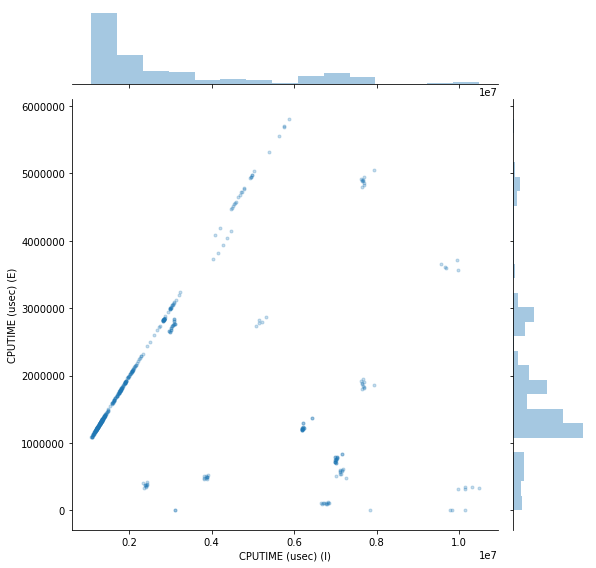

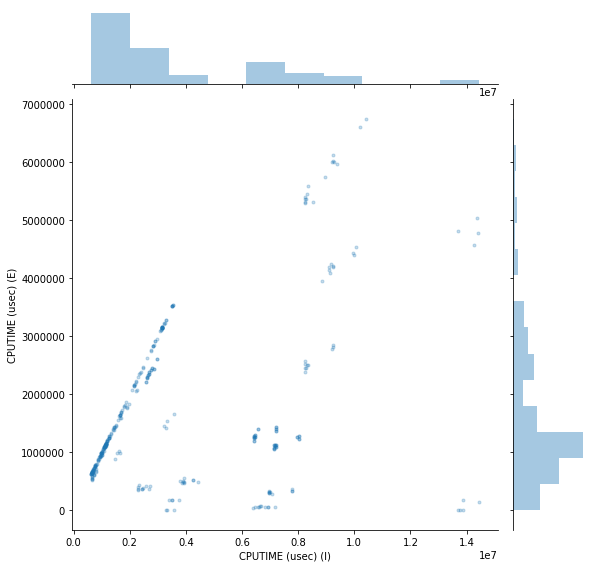

In [211]:
# Joint plot of the Inclusive and Exclusive times.
df = fgfs[0].dataframe
df2 = fgfs[1].dataframe
root_max_df = 107348942.00
root_max_df2 = 145114370.00
sns.jointplot('CPUTIME (usec) (I)', 'CPUTIME (usec) (E)',
              df.loc[(df['CPUTIME (usec) (I)'] < 0.10*107348942.00) &
                     (df['CPUTIME (usec) (E)'] > 0)],
              alpha=.25, marker='.', height=8);
sns.jointplot('CPUTIME (usec) (I)', 'CPUTIME (usec) (E)',
              df2.loc[(df2['CPUTIME (usec) (I)'] < 0.10*145114370.00) &
                     (df2['CPUTIME (usec) (E)'] > 0)],
              alpha=.25, marker='.', height=8);

In [212]:
def add_paths(state, path_name):
    for idx, row in state.df.iterrows():
        state.g.add_path(row[path_name])

In [213]:
def print_graph(states):
    for idx, state in enumerate(states):
        print(state.g.nodes())

In [214]:
def draw_graph(g):
    pos = nx.spectral_layout(g)
    nx.draw_networkx_nodes(g, pos, cmap=plt.get_cmap('jet'), 
                        node_size = 50)
    nx.draw_networkx_edges(g, pos, edge_color='b', arrows=True)


In [215]:
def add_levels(state):
    levelMap = {}
    track_level = 0
    nodes = state.g.nbunch_iter(state.root)
    
    for start_node in nodes:
        print("Start node", start_node)
        active_nodes = [start_node]
        levelMap[state.root] = 0
        
        for edge in nx.edge_dfs(state.g, start_node, 'original'):
            #rint("Edge {0}".format(edge))
            head_level = None
            tail_level = None
            head, tail = edge[0], edge[1]
            
            if head != start_node:
                active_nodes.append(head)
                
            if head in active_nodes and head != start_node and tail in active_nodes:
                #rint("Cycle", edge)
                edge_data = state.g.get_edge_data(*edge)                                                                             
                state.g.add_node(tail+'_')                                                                                           
                state.g.add_edge(head, tail+'_', data=edge_data)                                                                     
                state.g.node[tail+'_']['name'] = [tail + '_']                                                                        
                #state.g.node[tail+'_']['weight'] = state.g.node[tail]['weight']   
                state.g.remove_edge(edge[0], edge[1])
    return levelMap

In [216]:
 def flow_map(state):                                                                                                                 
        flowMap = {}                                                                                                                    
        nodes = state.g.nbunch_iter(state.root)                                                                                           
        for start_node in nodes:                                                                                                        
            for edge in nx.edge_dfs(state.g, start_node, 'original'):                                                                    
                head_level = None                                                                                                       
                tail_level = None                                                                                                       
                head, tail = self.tailhead(edge)                                                                                        
                                                                                                                                        
                # Check if there is an existing level mapping for the head node and assign.                                             
                if head in self.level_mapping.keys():                                                                                   
                    head_level =  self.level_mapping[head]                                                                              
                                                                                                                                        
                # Check if there is an existing level mapping for the tail node and assign.                                             
                if tail in self.level_mapping.keys():                                                                                   
                    tail_level = self.level_mapping[tail]                                                                               
                                                                                                                                        
                flowMap[(edge[0], edge[1])] = (int(head_level), int(tail_level))                                                        
        return flowMap 

In [217]:
def calculate_flows(state):
    graph = state.g
    ret = {}                                                                                                                                                                                                                                                                          
    edges = graph.edges()                                                                                                                                                                                                                                                             
    additional_flow = {}                                                                                                                                                                                                                                                              
                                                                                                                                                                                                                                                                                          
    # Calculates the costs in cycles and aggregates to one node.                                                                                                                                                                                                                      
    for edge in edges:                                                                                                                                                                                                                                                                
        source = edge[0]                                                                                                                                                                                                                                                              
        target = edge[1]                                                                                                                                                                                                                                                              
                                                                                                                                                                                                                                                                                          
        if source.endswith('_'):                                                                                                                                                                                                                                                      
            cycle_node = source                                                                                                                                                                                                                                                       
            cycle_node_df = self.state.lookup_with_nodeName(cycle_node[:-1])                                                                                                                                                                                                      
            additional_flow[cycle_node] = cycle_node_df['CPUTIME (usec) (I)'].max()                                                                                                                                                                                                   
        elif target.endswith('_'):                                                                                                                                                                                                                                                    
            cycle_node = target                                                                                                                                                                                                                                                       
            cycle_node_df = state.lookup_with_nodeName(cycle_node[:-1])                                                                                                                                                                                                      
            additional_flow[cycle_node] = cycle_node_df['CPUTIME (usec) (I)'].max()                                                                                                                                                                                                   
                                                                                                                                                                                                                                                                                          
    for edge in edges:                                                                                                                                                                                                                                                                
        added_flow = 0                                                                                                                                                                                                                                                                
        if edge[0].endswith('_'):                                                                                                                                                                                                                                                     
            ret[edge] = additional_flow[edge[0]]                                                                                                                                                                                                                                      
            continue                                                                                                                                                                                                                                                                  
        elif edge[1].endswith('_'):                                                                                                                                                                                                                                                   
            ret[edge] = additional_flow[edge[1]]                                                                                                                                                                                                                                      
            continue                                                                                                                                                                                                                                                                  
        source = state.lookup_with_nodeName(edge[0])                                                                                                                                                                                                                         
        target = state.lookup_with_nodeName(edge[1])                                                                                                                                                                                                                         
                                                                                                                                                                                                                                                                                          
        source_inc = source['CPUTIME (usec) (I)'].max()                                                                                                                                                                                                                               
        target_inc = target['CPUTIME (usec) (I)'].max()                                                                         
                                                                                                                                                                                                                                                                                          
        if source_inc == target_inc:                                                                                                                                                                                                                                                  
            ret[edge] = source_inc                                                                                                                                                                                                                                                    
        else:                                                                                                                                                                                                                                                                         
            ret[edge] = target_inc    
    return ret   

In [218]:
def add_edge_attributes(state):
    capacity_mapping = calculate_flows(state)    
    nx.set_edge_attributes(state.g, name='weight', values=capacity_mapping)

In [219]:
for idx, state in enumerate(states):
    state.g = nx.DiGraph()
    state.root = state.lookup_with_node(state.graph.roots[0])['name'][0]
    state.rootInc = state.lookup_with_node(state.graph.roots[0])['CPUTIME (usec) (I)'].max()
    add_paths(state, 'path')
    state.levelMap = add_levels(state)
    add_edge_attributes(state)  
    #draw_graph(state.g)

Start node <partial call paths>
Start node <partial call paths>


In [220]:
def create_flow_matrix(state):
    g = state.g
    nodes = g.nodes()
    
    state.nodeKey = {}
    for idx, node in enumerate(nodes):
        state.nodeKey[node] = idx
    
    flow_matrix = np.zeros(shape=(len(nodes),len(nodes)))
    flow_matrix.astype(float)
    
    for idx, node in enumerate(nodes):
        if idx == 0:
            neighbors = sorted(g[node].items(), key=lambda edge: edge[1]['weight'])
            for idx, n in enumerate(neighbors):
                sourceKey = int(state.nodeKey[node])
                targetKey = int(state.nodeKey[n[0]])
                weight = n[1]['weight']
                flow_matrix[sourceKey][targetKey] = n[1]['weight']/(1.0*state.rootInc)
    return flow_matrix

for idx, state in enumerate(states):
     state.flow_matrix = create_flow_matrix(state)

[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0.         0.99996864 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [221]:
xs = np.array([states[0].flow_matrix, states[1].flow_matrix])
print(xs)

[array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
 array([[0.        , 0.99996864, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])]


[array([[0., 1., 1., ..., 1., 1., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]]), array([[0., 1., 1., ..., 1., 1., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])]
[array([0.01162791, 0.01162791, 0.01162791, 0.01162791, 0.01162791,
       0.01162791, 0.01162791, 0.01162791, 0.01162791, 0.01162791,
       0.01162791, 0.01162791, 0.01162791, 0.01162791, 0.01162791,
       0.01162791, 0.01162791, 0.01162791, 0.01162791, 0.01162791,
       0.01162791, 0.01162791, 0.01162791, 0.01162791, 0.01162791,
       0.01162791, 0.01162791, 0.01162791, 0.01162791, 0.01162791,
       0.01162791, 0.01162791, 0.01162791, 0.01162791, 0.01162791,
       0.01162791, 0.01162791, 0.01162791, 0.

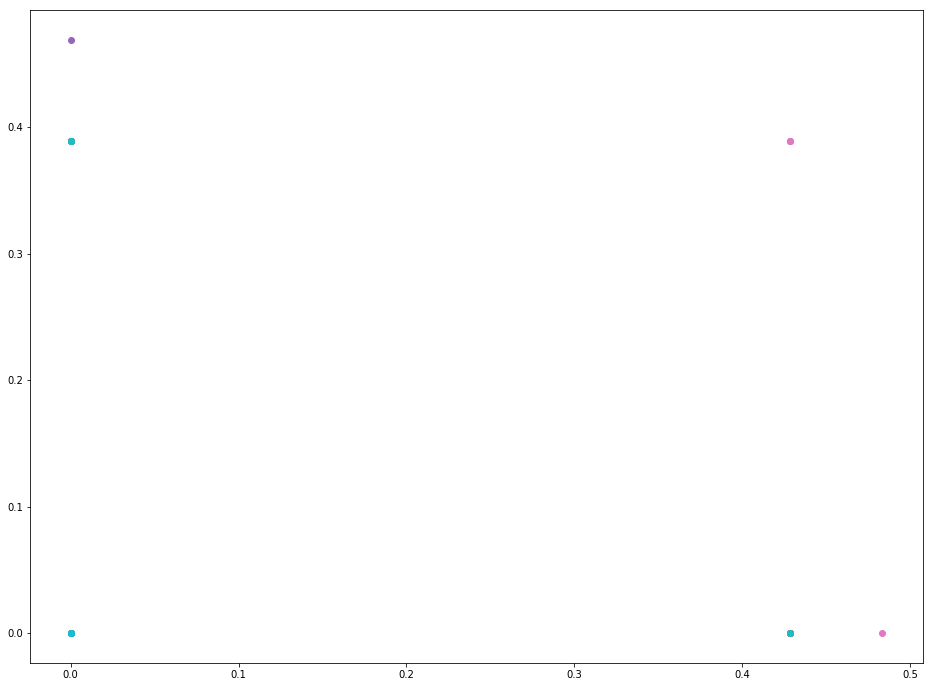

In [310]:
S = len(states)

ns = [len(xs[s]) for s in range(S)]
n_samples = 30

"""Compute all distances matrices for the four shapes"""
Cs = [sp.spatial.distance.cdist(xs[s], xs[s]) for s in range(S)]
Cs = [cs / cs.max() for cs in Cs]

print(Cs)
ps = [ot.unif(ns[s]) for s in range(S)]
p = ot.unif(n_samples)
print(ps)

lambdast = [[float(i) / 3, float(3 - i) / 3] for i in [1, 2]]

Ct01 = [0 for i in range(2)]
for i in range(S):
    Ct01[i] = ot.gromov.gromov_barycenters(n_samples, [Cs[0], Cs[1]],
                                           [ps[0], ps[1]
                                            ], p, lambdast[i], 'square_loss',  # 5e-4,
                                           max_iter=100, tol=1e-3)


plt.plot(Ct01[0], Ct01[1], 'o', label = 'Ct01')
plt.show()


In [223]:
def smacof_mds(C, dim, max_iter=3000, eps=1e-9):
    """
    Returns an interpolated point cloud following the dissimilarity matrix C
    using SMACOF multidimensional scaling (MDS) in specific dimensionned
    target space

    Parameters
    ----------
    C : ndarray, shape (ns, ns)
        dissimilarity matrix
    dim : int
          dimension of the targeted space
    max_iter :  int
        Maximum number of iterations of the SMACOF algorithm for a single run
    eps : float
        relative tolerance w.r.t stress to declare converge

    Returns
    -------
    npos : ndarray, shape (R, dim)
           Embedded coordinates of the interpolated point cloud (defined with
           one isometry)
    """

    rng = np.random.RandomState(seed=3)

    mds = manifold.MDS(
        dim,
        max_iter=max_iter,
        eps=1e-9,
        dissimilarity='precomputed',
        n_init=1)
    pos = mds.fit(C).embedding_

    nmds = manifold.MDS(
        2,
        max_iter=max_iter,
        eps=1e-9,
        dissimilarity="precomputed",
        random_state=rng,
        n_init=1)
    npos = nmds.fit_transform(C, init=pos)

    return npos

[array([[-1.42926355e-02,  1.27414000e-10],
       [-1.42926355e-02, -6.58769081e-11],
       [-1.42926355e-02, -6.34832268e-11],
       [-1.42926355e-02, -1.97438599e-10],
       [-1.42926355e-02,  1.54025089e-11],
       [-1.42926355e-02,  1.91973191e-10],
       [-1.42926355e-02,  2.14949563e-10],
       [-1.42926355e-02, -1.12927467e-10],
       [-1.42926355e-02,  3.51367241e-11],
       [-1.42926355e-02, -1.84019828e-10],
       [-1.42926355e-02,  1.49656157e-10],
       [-1.42926355e-02, -2.01417117e-10],
       [-1.42926355e-02,  1.93870197e-10],
       [-1.42926355e-02,  1.25966535e-10],
       [-1.42926355e-02,  1.26698861e-10],
       [-1.42926355e-02,  8.51292341e-11],
       [ 4.14486430e-01,  1.76909549e-18],
       [-1.42926355e-02, -1.08515680e-10],
       [-1.42926355e-02, -2.15420533e-10],
       [-1.42926355e-02,  1.97587447e-10],
       [-1.42926355e-02,  1.08638290e-10],
       [-1.42926355e-02,  4.89206965e-11],
       [-1.42926355e-02, -1.59694350e-10],
       [-1

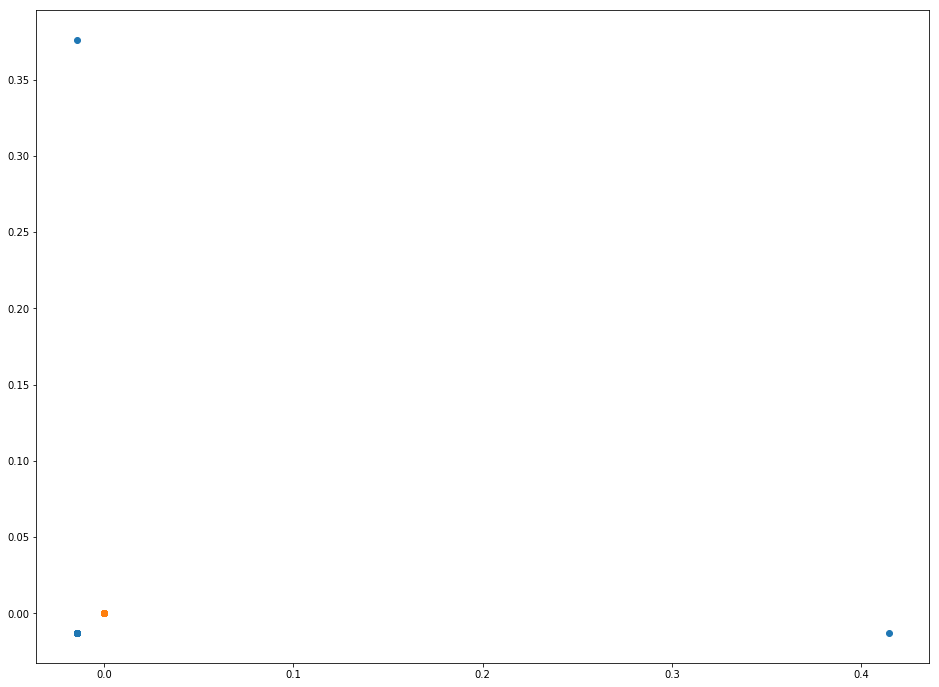

ValueError: x and y must have same first dimension, but have shapes (86, 2) and (64, 2)

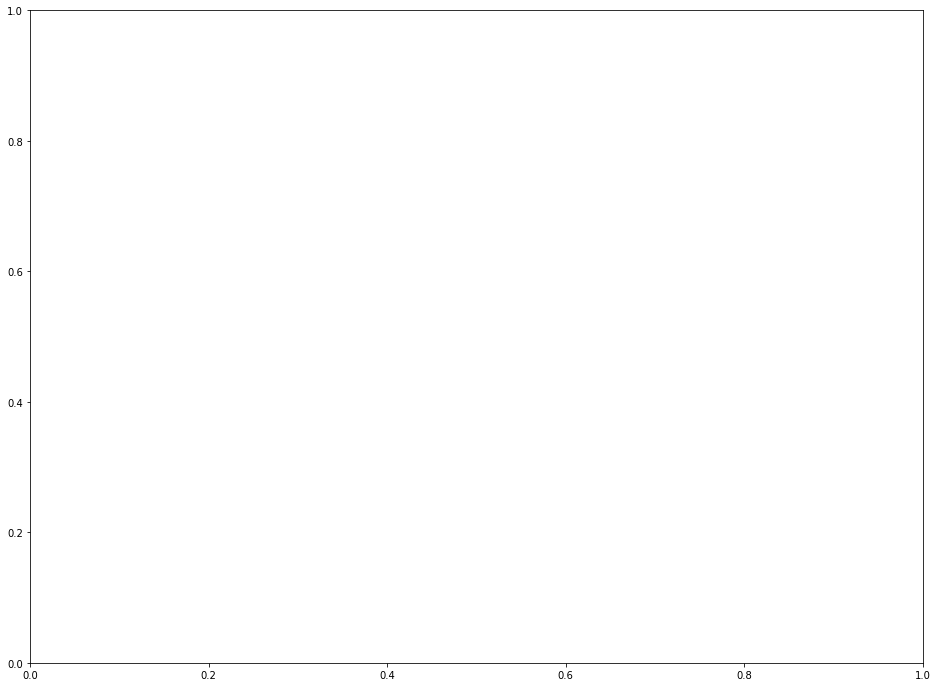

In [312]:
clf = PCA(n_components=2)
npos = [0, 0]
npos = [smacof_mds(Cs[s], 2) for s in range(S)]

npost01 = [0, 0]
npost01 = [smacof_mds(Ct01[s], 2) for s in range(2)]
npost01 = [clf.fit_transform(npost01[s]) for s in range(2)] 

print(npost01)
plt.plot(npost01[0], npost01[1], 'o', label = 'npost01')
plt.show()

plt.plot(npos[0], npos[1], 'o', label = 'npos')
plt.show()

nx01min = npos[0][0][0]
nx01max = npos[0][0][0]
ny01min = npos[0][1][1]
ny01max = npos[0][1][1]

nx02min = npos[1][0][0]
nx02max = npos[1][0][0]
ny02min = npos[1][1][1]
ny02max = npos[1][1][1]

for idx, arr in enumerate(npos):
    if arr[0][0] < nx01min:
        nx01min = arr[0][0]
    else:
        pass
    
    if arr[0][1] > nx01max:
        nx01max = arr[0][1]
    else:
        pass
    
    if arr[1][0] < ny01min:
        ny01min = arr[1][0]
    else:
        pass
    
    if arr[1][1] > ny01max:
        ny01max = arr[1][1]
    else:
        pass


for idx, arr in enumerate(npost01):
    if arr[0][0] < nx02min:
        nx02min = arr[0][0]
    else:
        pass
    
    if arr[0][1] > nx02max:
        nx02max = arr[0][1]
    else:
        pass
    
    if arr[1][0] < ny02min:
        ny02min = arr[1][0]
    else:
        pass
    
    if arr[1][1] > ny02max:
        ny02max = arr[1][1]
    else:
        pass

fig = plt.figure(figsize=(10, 10))

x1 = []
y1 = []
for idx, val in enumerate(npost01[0]):
    x1.append(val[0])
    y1.append(val[1])
    
x2 = []
y2 = []
for idx, val in enumerate(npost01[1]):
    x2.append(val[0])
    y2.append(val[1])

x1 = np.asarray(x1)
x2 = np.asarray(x2)
y1 = np.asarray(y1)
y2 = np.asarray(y2)

x1min = np.minimum(x1)
x2min = np.minimum(x2)
x1max = np.maximum(x1)
x2max = np.maximum(x2)

y1min = np.minimum(y1)
y2min = np.minimum(y2)
y1max = np.maximum(y1)
y2max = np.maximum(y2)
#ax1 = plt.subplot2grid((1, 1), (0, 0))  
#plt.xlim((nx01min - 0.1, nx01max + 0.1))
#plt.ylim((ny01min - 0.1, ny01max + 0.1))
#ax1.scatter(npos[0][:, 0], npos[0][:, 1], color='r')

ax2 = plt.subplot2grid((1, 2), (0, 1))
plt.xlim(x1min, x1max)
plt.ylim(y1min, y1max)
ax2.scatter(x1, y1, color='b')
ax2.scatter(x2, y2, color='r')

print(x1, x2)
print(y1, y2)